Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


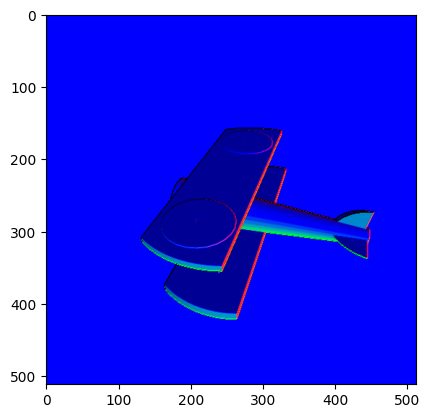

In [1]:
import torch
import matplotlib.pyplot as plt
from pytorch3d.io import load_objs_as_meshes
from pathlib import Path
from neural_poisson.data.prepare import (
    extract_surface_data,
    uniform_sphere_cameras,
    sample_empty_space_points,
    subsample_points,
    estimate_vector_field_nearest_neighbors
)

# settings
image_size = 512
segments = 10
device = "cuda"
model_id = "1a04e3eab45ca15dd86060f189eb133"

# define the paths
root_dir = Path("/home/borth/2d-gaussian-splatting/")
shapenet_dir = root_dir / "data/ShapeNetCoreTiny/02691156"
shapenet_path = shapenet_dir / model_id / "models/model_normalized.obj"

# load the mesh and the cameras
mesh = load_objs_as_meshes([shapenet_path], device=device)
cameras = uniform_sphere_cameras(segments=segments, device=device)

# visualize a camera
elev = 8
azim = 1
data = extract_surface_data(
    camera=cameras[elev + azim * segments],
    mesh=mesh,
    image_size=image_size,
)
normal = torch.clip(data["normal_map"][0], 0.0, 1.0)
plt.imshow(normal.detach().cpu().numpy())

In [2]:
normals = []
points = []
for camera in cameras[:5]:
    data = extract_surface_data(camera=camera, mesh=mesh, image_size=image_size)
    normals.append(data["normals"])
    points.append(data["points"])
normals = torch.cat(normals) 
points = torch.cat(points) 
vectors = estimate_vector_field_nearest_neighbors(
    points=points,
    normals=normals,
    query=points,
    k=10,
    sigma=1.0,
)

In [ ]:
import open3d as o3d

pcd = o3d.geometry.PointCloud()
pcd.points = o3d.utility.Vector3dVector(points.detach().cpu().numpy())

pcd.normals = o3d.utility.Vector3dVector(vectors.detach().cpu().numpy())
o3d.visualization.draw_plotly([pcd])

In [38]:
camera = cameras[0]
data = extract_surface_data(camera=camera, mesh=mesh, image_size=image_size)
p_e = sample_empty_space_points(
    points=data["points"],
    camera=camera,
    surface_threshold=1.0,
    samples=4,
)
p_e = subsample_points(points=p_e, resolution=0.01)


In [278]:
import open3d as o3d

k = 20
sigma = 1.0
threshold = 30 
points = data["points"]  # the surface points
normals = data["normals"]  # the normals on the surface
query = data["points"]  # the target points to evaluate the vector field
chunk_size = 1_000
normalize = True

vectors = []
for q in torch.split(query, chunk_size):
    # compute the distances
    distances = torch.cdist(q, points, p=2)
    distances, indices = torch.topk(distances, k, dim=1, largest=False)

    # gaussian-weighted average of the k nearest neighbors
    weights = torch.exp(-distances / (2 * sigma))

    # compute the clusters
    cluster_idxs = torch.full_like(indices, -1)
    cluster_idxs[:, 0] = 0
    for i in range(1, k):
        prev_idxs = cluster_idxs[:, :i]
        prev_max_cluster = prev_idxs.max(dim=-1).values

        # default is just the next index
        current_normal = normals[indices][:, i, :]
        current_idxs = prev_max_cluster + 1
        tmp_cluster_similarity = -torch.ones(q.shape[0]).to(q) # fill with -1

        # compute the previous cluster vectors
        for j in range(0, i):
            # activate the current cluster by disabeling all others
            cluster_weights = weights.clone()
            cluster_weights[cluster_idxs != j] = 0.0
            cluster_vector = (normals[indices] * cluster_weights.unsqueeze(-1)).sum(-2)
            cluster_vector /= cluster_weights.sum(-1, keepdim=True)

            # compute cosine similartiy between cluster vector and current vector
            similarity = (cluster_vector * current_normal).sum(-1)
            similarity /= torch.linalg.vector_norm(cluster_vector, dim=-1)
            similarity /= torch.linalg.vector_norm(current_normal, dim=-1)

            # compute the angle 
            theta = torch.rad2deg(torch.acos(similarity))

            # update the best cluster
            mask = (similarity > tmp_cluster_similarity) & (theta <= threshold) 
            tmp_cluster_similarity[mask] = similarity[mask]
            current_idxs[mask] = j

        # if there is a cluster that matches 
        cluster_idxs[:, i] = current_idxs
    
    # evalute the cluster normals and centers
    cluster_vectors = []
    cluster_centers = []
    for j in range(0, k):
        # activate the current cluster by disabeling all others
        cluster_weights = weights.clone()
        cluster_weights[cluster_idxs != j] = 0.0
        cluster_vector = (normals[indices] * cluster_weights.unsqueeze(-1)).sum(-2)
        cluster_vector /= cluster_weights.sum(-1, keepdim=True)
        cluster_vectors.append(cluster_vector)
        # activate the current cluster centers
        cluster_center = (points[indices] * cluster_weights.unsqueeze(-1)).sum(-2)
        cluster_centers.append(cluster_center)
    cluster_centers = torch.stack(cluster_centers, dim=1)  # (P,C,3)
    cluster_vectors = torch.stack(cluster_vectors, dim=1)  # (P,C,3)

    # select the cluster normal with the clostest cluster center
    distances = q.unsqueeze(-2) - cluster_centers
    distances = torch.linalg.vector_norm(distances, dim=-1)  # (Q, C)
    # reset the distances with no values
    idxs = torch.arange(distances.shape[1]).expand(distances.shape[0], -1).to(distances)
    mask = idxs > (cluster_idxs.max(dim=-1).values)[..., None]
    distances[mask] = torch.nan
    distances, indices = torch.topk(distances, 1, dim=1, largest=False)
    indices = indices[..., 0]  # just the top 1
    # the final cluster vectors
    vector = cluster_vectors[torch.arange(cluster_vectors.shape[0]), indices]

    # normalize the vector field to contain only normal vectors
    if normalize:
        vector /= torch.linalg.vector_norm(vector, dim=-1).unsqueeze(-1)
    vectors.append(vector)

vectors = torch.cat(vectors)

In [303]:
points = data["points"]  # the surface points
normals = data["normals"]  # the normals on the surface
query = data["points"]  # the target points to evaluate the vector field

vectors = []
for q in torch.split(query, chunk_size):
    # compute the distances
    distances = torch.cdist(q, points, p=2)
    distances, indices = torch.topk(distances, 1, dim=1, largest=False)
    vector = normals[indices[..., 0]]
    # normalize the vector field to contain only normal vectors
    if normalize:
        vector /= torch.linalg.vector_norm(vector, dim=-1).unsqueeze(-1)
    vectors.append(vector)
v = torch.cat(vectors)


In [304]:
normals

tensor([[ 6.8247e-01, -6.8247e-01, -2.6168e-01],
        [ 4.4799e-04, -9.9429e-01, -1.0668e-01],
        [ 1.4353e-04, -9.9430e-01, -1.0660e-01],
        ...,
        [-8.3596e-04,  9.6824e-01, -2.5001e-01],
        [-8.3705e-04,  9.6824e-01, -2.5002e-01],
        [-7.0019e-01,  7.0029e-01, -1.3902e-01]], device='cuda:0')

In [306]:
v


tensor([[ 6.8247e-01, -6.8247e-01, -2.6168e-01],
        [ 4.4799e-04, -9.9429e-01, -1.0668e-01],
        [ 1.4353e-04, -9.9430e-01, -1.0660e-01],
        ...,
        [-8.3596e-04,  9.6824e-01, -2.5001e-01],
        [-8.3705e-04,  9.6824e-01, -2.5002e-01],
        [-7.0019e-01,  7.0029e-01, -1.3902e-01]], device='cuda:0')

In [ ]:
# compute the cluster vectors


# _cluster_centers = cluster_centers[:100]
# _query = query[:100]
# _cluster_vectors = cluster_vectors[:100]
# _cluster_idx = cluster_idxs[:100].max(dim=-1).values

# compute the distances
distances = q.unsqueeze(-2) - cluster_centers
distances = torch.linalg.vector_norm(distances, dim=-1)  # (Q, C)
# reset the distances with no values
idxs = torch.arange(distances.shape[1]).expand(distances.shape[0], -1).to(distances)
mask = idxs > (cluster_idxs.max(dim=-1).values)[..., None]
distances[mask] = torch.nan
distances, indices = torch.topk(distances, 1, dim=1, largest=False)
indices = indices[..., 0]  # just the top 1
# the final cluster vectors
vectors = cluster_vectors[torch.arange(cluster_vectors.shape[0]), indices]

In [143]:
cluster_idxs[0]

tensor([0, 0, 1, 1, 0, 1, 1, 1, 2, 2, 2, 0, 2, 1, 2, 2, 2, 2, 1, 2],
       device='cuda:0')

In [142]:
cluster_centers[0]

tensor([[-0.0562, -0.2014,  1.4606],
        [-0.0661, -0.3600,  2.5560],
        [-0.1036, -0.4490,  3.2861],
        [ 0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000]], device='cuda:0')

In [48]:
query.shape, points.shape, cluster_centers.shape

(torch.Size([20176, 3]), torch.Size([15651, 3]), torch.Size([20176, 20, 3]))

torch.Size([100, 20, 3]) torch.Size([100])


RuntimeError: The expanded size of the tensor (3) must match the existing size (100) at non-singleton dimension 1.  Target sizes: [-1, 3].  Tensor sizes: [100]

torch.Size([100, 3])

In [ ]:
distances.shape
idxs = torch.arange(distances.shape[1]).expand(distances.shape[0], -1).to(distances)
mask = idxs > (_cluster_idx)[..., None]
distances[mask] = distances.max() + 1
distances

tensor([[0.8125, 1.9191, 2.6552,  ..., 6.0738, 6.0738, 6.0738],
        [0.3924, 0.3936, 3.9122,  ..., 6.0738, 6.0738, 6.0738],
        [1.0670, 1.0673, 2.8542,  ..., 6.0738, 6.0738, 6.0738],
        ...,
        [0.0753, 0.3622, 0.0770,  ..., 6.0738, 6.0738, 6.0738],
        [2.0547, 2.0665, 6.0738,  ..., 6.0738, 6.0738, 6.0738],
        [0.9612, 1.1703, 0.0065,  ..., 6.0738, 6.0738, 6.0738]],
       device='cuda:0')

In [187]:
cluster_centers[0]
query[0]
idx = cluster_idxs[0].max(dim=-1).values
# distances[0]
v = torch.linalg.vector_norm(query[0]-cluster_centers[0], dim=-1)
v[idx+1:] = v.max() + 1
v

tensor([0.8125, 1.9191, 2.6552, 3.6552, 3.6552, 3.6552, 3.6552, 3.6552, 3.6552,
        3.6552, 3.6552, 3.6552, 3.6552, 3.6552, 3.6552, 3.6552, 3.6552, 3.6552,
        3.6552, 3.6552], device='cuda:0')

In [242]:
# BUG
indices < _cluster_idxs  # the indices should not be able to be bigger then cluster_idxs

tensor([[False, False,  True,  ...,  True,  True,  True],
        [False, False, False,  ..., False, False, False],
        [False, False,  True,  ...,  True,  True,  True],
        ...,
        [False,  True,  True,  ...,  True,  True,  True],
        [False, False, False,  ...,  True, False,  True],
        [False, False, False,  ..., False, False, False]], device='cuda:0')

In [255]:
indices.squeeze(-1) <= _cluster_idxs.max(dim=-1).values

tensor([True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True], device='cuda:0')

In [252]:
indices.unsqueeze(-1).shape

torch.Size([100, 1, 1])

In [ ]:
_cluster_idxs.max(dim=-1).values

torch.Size([100])

In [125]:
torch.isnan(cluster_vectors[:, 0, :]).sum()

tensor(0, device='cuda:0')

In [ ]:
torch.lin

q = query[:100]  # (Q, 3)
distances = torch.cdist(cluster_centers, query[:100], p=2)
# distances, indices = torch.topk(distances, 1, dim=0, largest=False)
# cluster_vector.shape
distances.shape

torch.Size([20176, 20, 100])

In [12]:
distances.shape

torch.Size([20, 100, 20447])

In [ ]:
idx = 5000
print(cluster_idxs[idx])
pcd = o3d.geometry.PointCloud()
pcd.points = o3d.utility.Vector3dVector(points[indices[idx]].detach().cpu().numpy())
pcd.normals = o3d.utility.Vector3dVector(normals[indices[idx]].detach().cpu().numpy())
o3d.visualization.draw_plotly([pcd])

In [ ]:
idx = 5000
cluster = 4
print(cluster_idxs[idx])
pcd = o3d.geometry.PointCloud()
pcd.points = o3d.utility.Vector3dVector(points[indices[idx]][cluster_idxs[idx]==cluster].detach().cpu().numpy())
pcd.normals = o3d.utility.Vector3dVector(normals[indices[idx]][cluster_idxs[idx]==cluster].detach().cpu().numpy())
o3d.visualization.draw_plotly([pcd])

In [ ]:
points[indices[idx]][cluster_idxs[idx]==0]

In [ ]:
normals[indices].shape

In [ ]:
k = 1
prev_idxs = cluster_idxs[:, :k]
# default is just the next index
prev_max_cluster = prev_idxs.max(dim=-1).values
current_idxs = prev_max_cluster + 1
current_idxs

In [ ]:
distances.shape